# PREVENDO NUMERO DE MORTES DIÁRIAS POR COVID NO BRASIL UTILIZANDO SÉRIES TEMPORAIS

Para este exemplo, nós iremos utilizar o modelo SARIMA. O SARIMA nada mais é que o ARIMA com o componente S de sazonal.


Para o SARIMA, precisamos selecionar alguns parâmetros para os elementos de tendência e sazonalidade da série.

Exitem três elementos de tendência. Estes são os mesmos do modelo ARIMA.

* *p*: Ordem do AR 
* *d*: Ordem do número de diferenciamentos necessários para tornar a série temporal estacionária
* *q*: Ordem do termo MA

Elementos sazonais 

Existem quatro elementos sazonais que não fazem parte do ARIMA 

* *P*: Ordem do AR sazonal 
* *D*: Ordem de diferenças sazonais 
* *Q*: Ordem de MA sazonal 
* *s*: Número de períodos referentes ao ciclo sazonal 

A notação do SARIMA é definida como SARIMA$(p, q, d)$$(P, Q, D)s$.

É importante frizar que a escolha dos coeficiêntes sazonais $P$, $D$ e $Q$ é influênciada pelo valor de $S$, onde um modelo $S$ = 12 para meses, sugere uma sazonalidade 
de ciclo anual, assim, $P$ = 2 sugere que existe uma dependência linear entre o valor do periodo $t$ e os valores dos períodos ($t$ - $s$) e ($t$ - $s$ * 2). 

In [468]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from warnings import simplefilter
import statsmodels.api as sm
import itertools
simplefilter("ignore")

#### Ler o dataset

In [469]:
df = pd.read_csv("owid-covid-data.csv")

In [470]:
df_brasil = df[df["location"] == "Brazil"]

In [471]:
columns = ["date", "new_deaths"]
df_brasil = df_brasil[columns]

#### Substitui os NaN's por 0, porque estamos contando o numero de morte diárias e eventualmente, pode em algum dia, não ter mortes.

In [472]:
df_brasil[['new_deaths']].isnull().sum()

new_deaths    20
dtype: int64

In [473]:
df_brasil[['new_deaths']].head(10)

,new_deaths
16214,NaN
16215,NaN
16216,NaN
16217,NaN
16218,NaN
16219,NaN
16220,NaN
16221,NaN
16222,NaN
16223,NaN


In [474]:
df_brasil['new_deaths'] = df_brasil[['new_deaths']].fillna(0)

In [475]:
df_brasil[['new_deaths']]

,new_deaths
16214,0.0
16215,0.0
16216,0.0
16217,0.0
16218,0.0
...,...
16823,433.0
16824,389.0
16825,394.0
16826,232.0


#### Analisando tedências

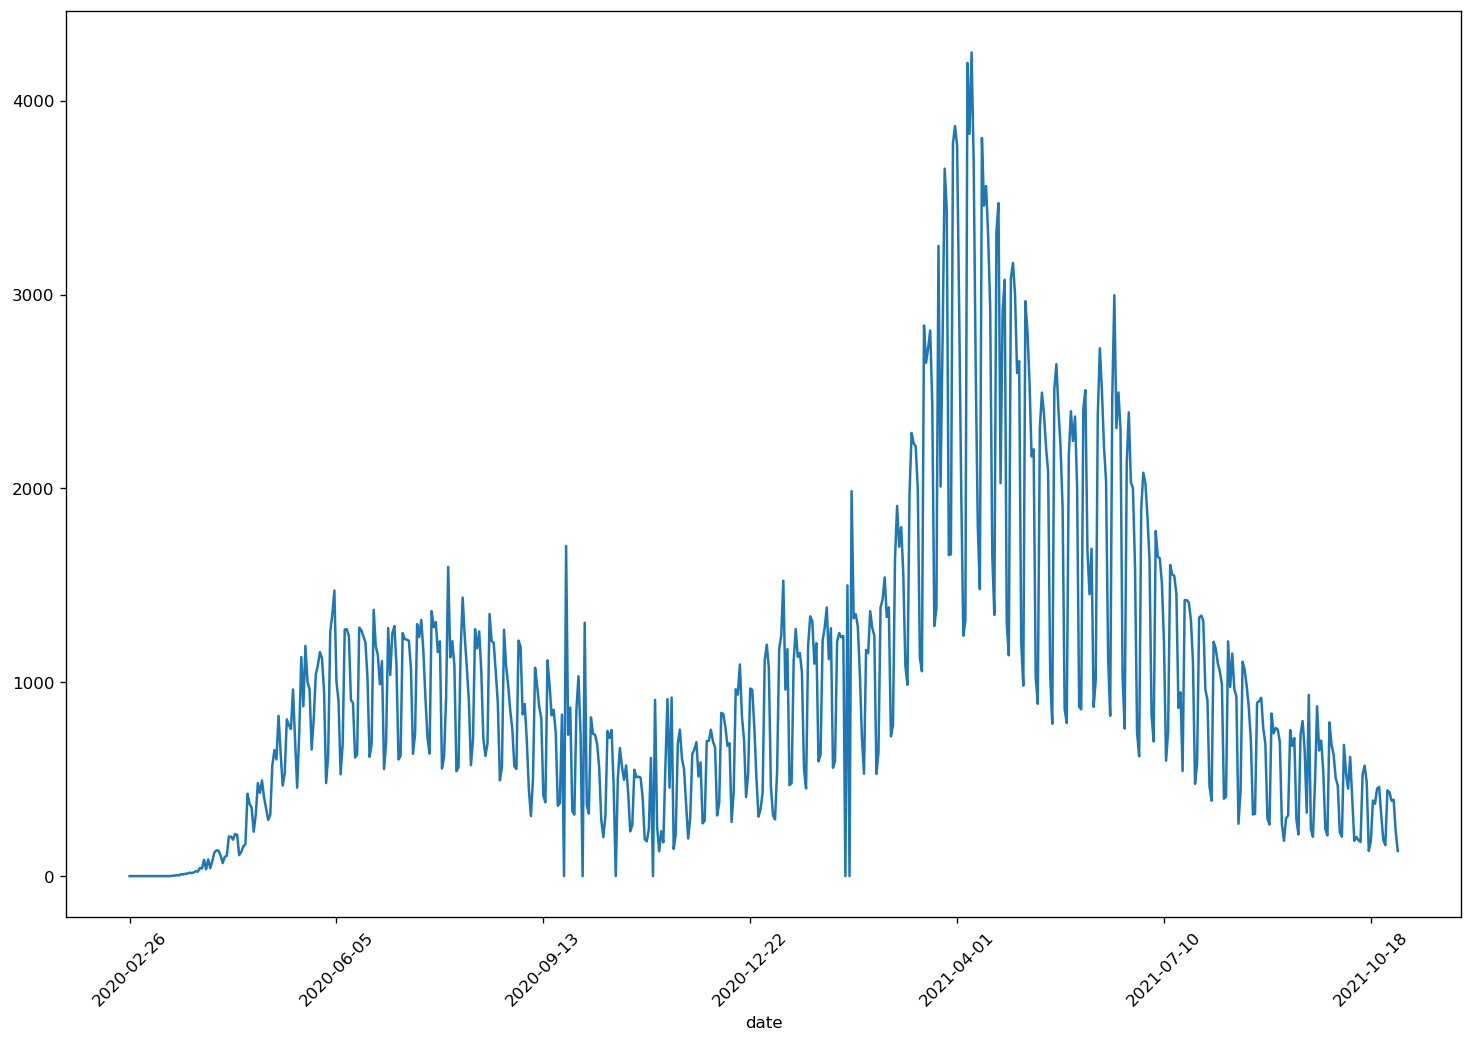

In [476]:
df_brasil.set_index("date").new_deaths.plot(figsize=(15, 10))
plt.xticks(rotation=45)
plt.show();

#### Verificando a parte não sazional do arima

##### Transformando a coluna date em DateTimeIndex

In [477]:
df_brasil = df_brasil.set_index(pd.DatetimeIndex(df_brasil['date'])).drop("date", axis=1)

##### plota a decomposição da série

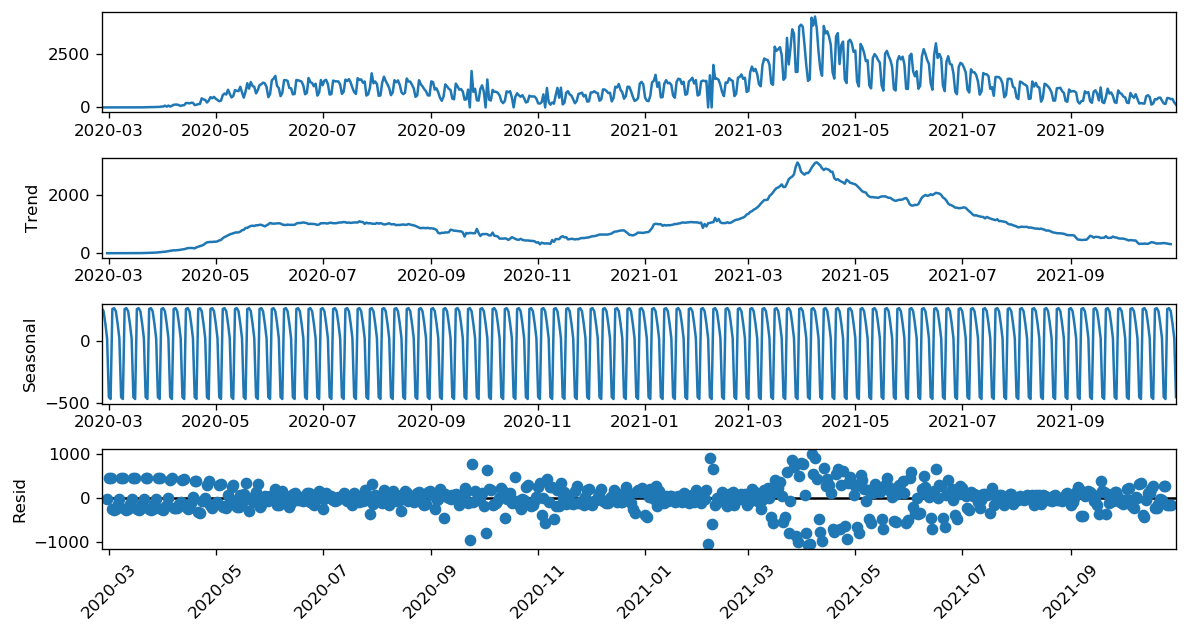

In [478]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = (10,5)

series =  df_brasil
result = seasonal_decompose(series)

result.plot()
plt.xticks(rotation=45);

##### Plota as ordens de difererenciações para encontrar "d".

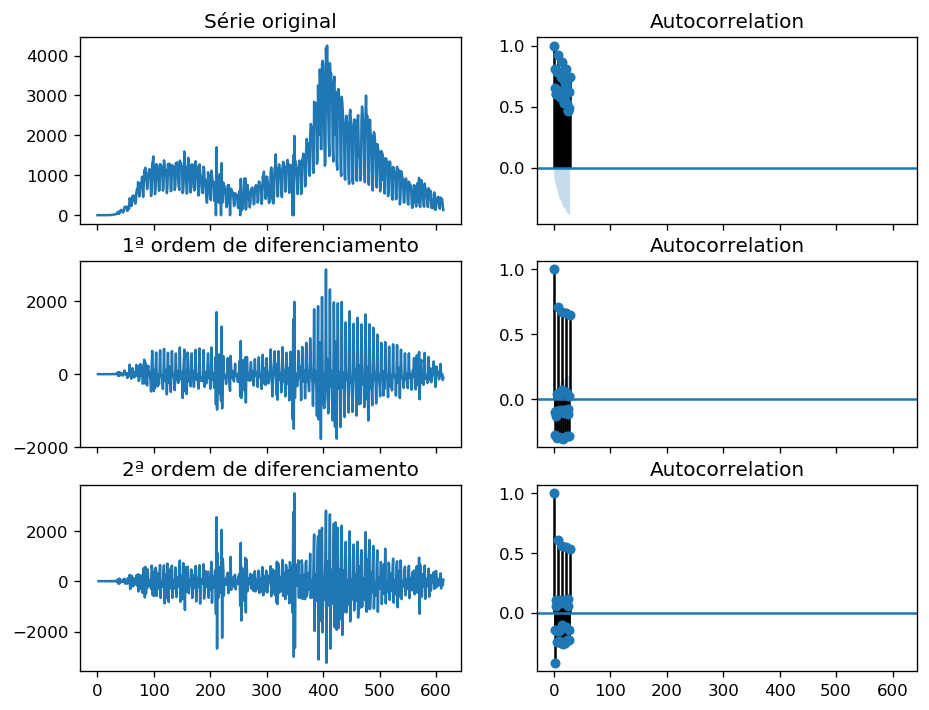

In [479]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

original_serie = df_brasil.reset_index().new_deaths

fig, axes = plt.subplots(3, 2, sharex=True)

axes[0, 0].plot(original_serie); 

axes[0, 0].set_title('Série original')
plot_acf(original_serie, ax=axes[0, 1])

# 1ª ordem de diferenciamento
axes[1, 0].plot(original_serie.diff().dropna());

axes[1, 0].set_title('1ª ordem de diferenciamento')
plot_acf(original_serie.diff().dropna().dropna(), ax=axes[1, 1])



# 2ª ordem de diferenciamento
axes[2, 0].plot(original_serie.diff().diff().dropna()); 

axes[2, 0].set_title('2ª ordem de diferenciamento')
plot_acf(original_serie.diff().diff().dropna(), ax=axes[2, 1])
plt.show()

##### Teste estátistico de estacionariedade da série com Dickey-Fuller

* Se p-value for menor que  0.05, então, minha série é estácionária, caso contrária, não é estácionária. 

In [480]:
from statsmodels.tsa.stattools import adfuller

# teste sem diferenciação
result = adfuller(df_brasil.new_deaths)
print('Estátistica ADF: %f' % result[0])
print('p-value: %f' % result[1])

Estátistica ADF: -2.074180
p-value: 0.255023


In [481]:
# teste com diferenciação de 1ª ordem

result = adfuller(df_brasil.new_deaths.diff().dropna())
print('Estátistica ADF: %f' % result[0])
print('p-value: %f' % result[1])

Estátistica ADF: -4.507889
p-value: 0.000190


In [482]:
# teste com diferenciação de 2ª ordem

result = adfuller(df_brasil.new_deaths.diff().diff().dropna())
print('Estátistica ADF: %f' % result[0])
print('p-value: %f' % result[1])

Estátistica ADF: -10.485009
p-value: 0.000000


##### Utilizando outros testes de estacionariedade para encontrar o melhor numero de diferenciações da minha série
* Dickey fuller test
* Kwiatkowski – Phillips – Schmidt – Shin test
* Phillips–Perron test

In [483]:
from pmdarima.arima.utils import ndiffs

y = df_brasil.new_deaths

list_tests = ['adf', 'kpss', 'pp']


for tests in list_tests:
    print(f'''Numero de diferenciações com o teste: {tests} = {ndiffs(y, test= tests)}''')



Numero de diferenciações com o teste: adf = 1
Numero de diferenciações com o teste: kpss = 1
Numero de diferenciações com o teste: pp = 0


##### Plota o gráfico de correlação parcial para encontrar  o termo "p"

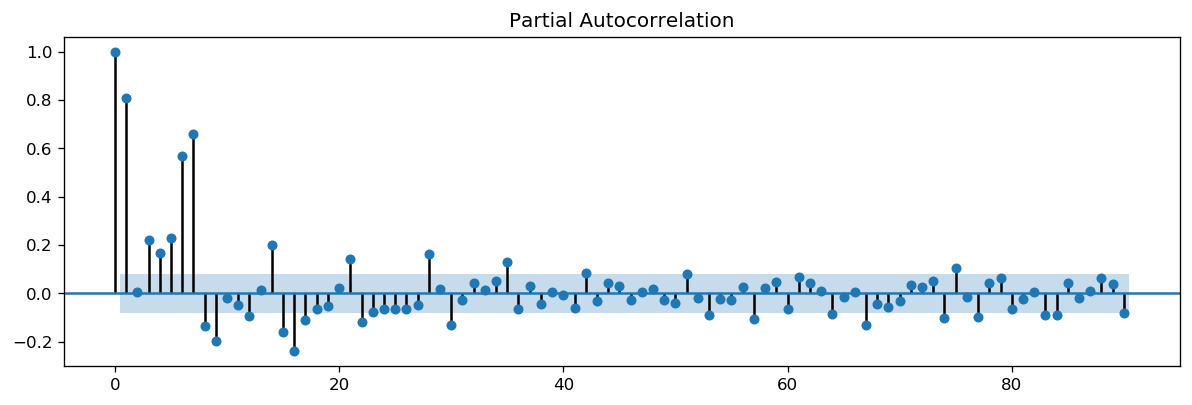

In [484]:
fig = plt.figure(figsize=(12, 8))
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_brasil.new_deaths, lags=90, ax=ax2)
plt.show()

##### Plota o gráfico autocorrelação para encontrar  o termo "q"

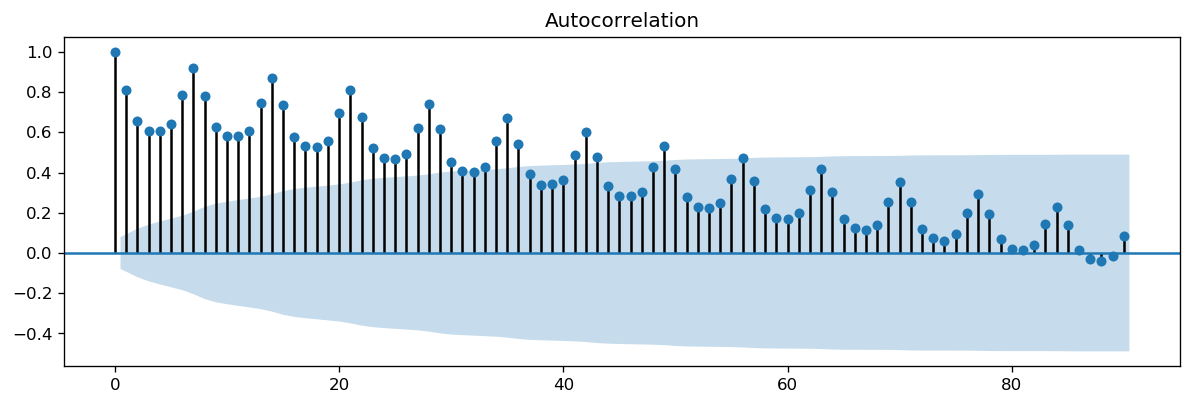

In [485]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_brasil.new_deaths, lags=90, ax=ax1)

##### Separa os dados de treino e teste

In [486]:
#Split Data
size_train = round((df_brasil.new_deaths.shape[0] * 0.9))

# Create Training and Test
df_train = df_brasil[0:size_train]
df_test = df_brasil[size_train:]

train = df_train.new_deaths
test = df_test.new_deaths

In [487]:
train.shape, test.shape

((553,), (61,))

#### Treina o modelo

In [574]:
%%time
model=sm.tsa.statespace.SARIMAX(train, 
                                freq='D', 
                                order=(1, 1, 2), seasonal_order=(0, 1, 1, 7),
                                trend='ctt'
                               )

results=model.fit()

Wall time: 2.44 s


##### Erro residual médio 

In [575]:
(results.resid ** 2).mean()

70364.12147790959

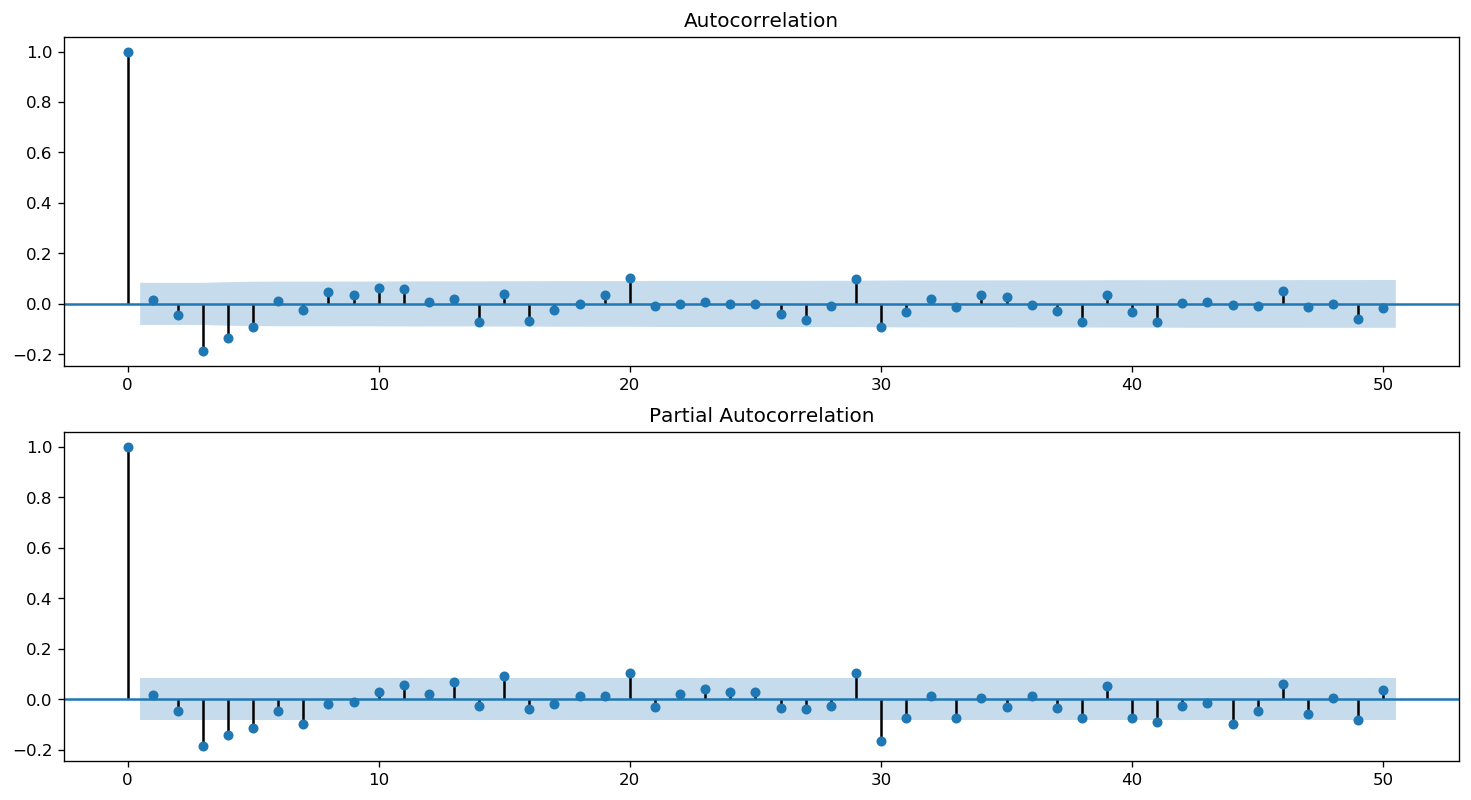

In [576]:
res = results.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

##### Calcula erro médio quadrático

In [577]:
from sklearn.metrics import mean_squared_error
pred = results.predict(test.index.min(), test.index.max()).apply(lambda x: "{:.0f}".format(x))
print('SARIMAX model MSE:{}'.format(mean_squared_error(test, y_pred)))

SARIMAX model MSE:44898.27868852459


#### Avalia o modelo

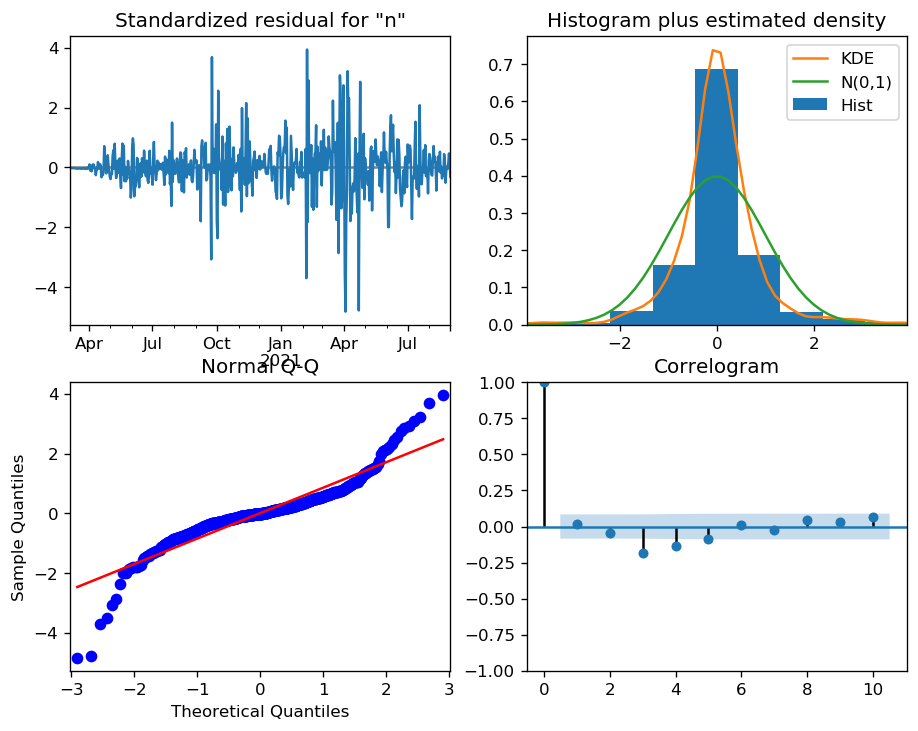

In [578]:
results.plot_diagnostics();

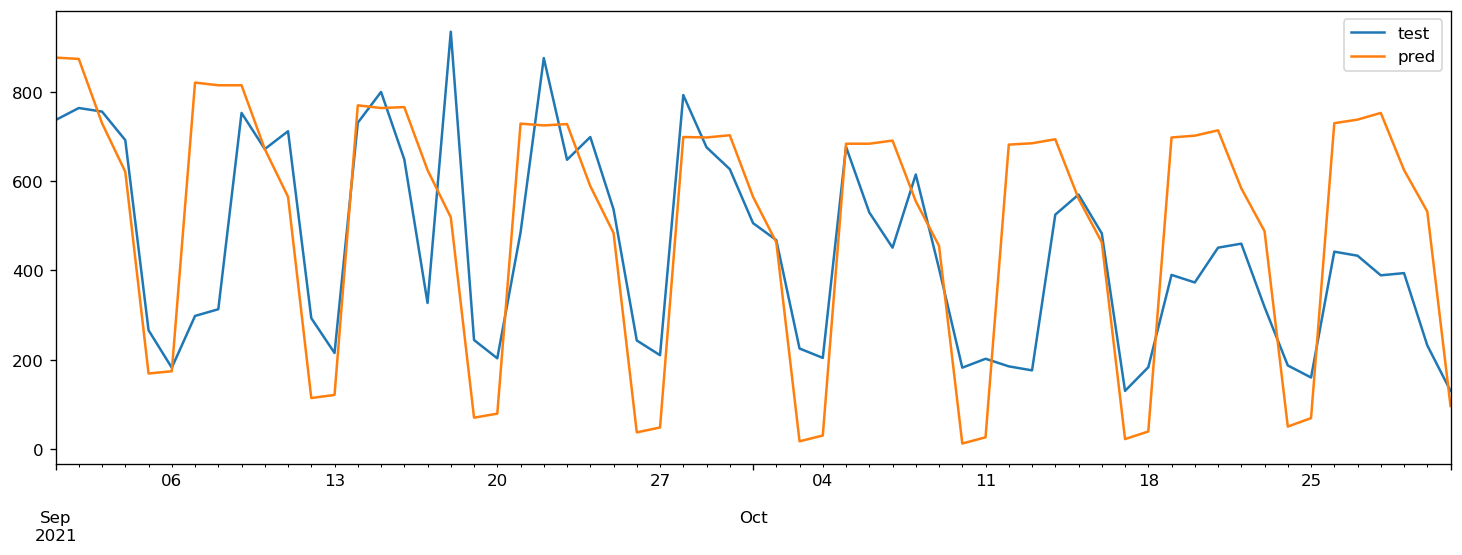

In [579]:
pred = results.predict(test.index.min(), test.index.max()).apply(lambda x: "{:.0f}".format(x))

pd.DataFrame({"test": test.apply(lambda x: "{:.0f}".format(x)), "pred": pred}).astype(float).plot(figsize=(15, 5))

##### Plota a série original comparando com o predito

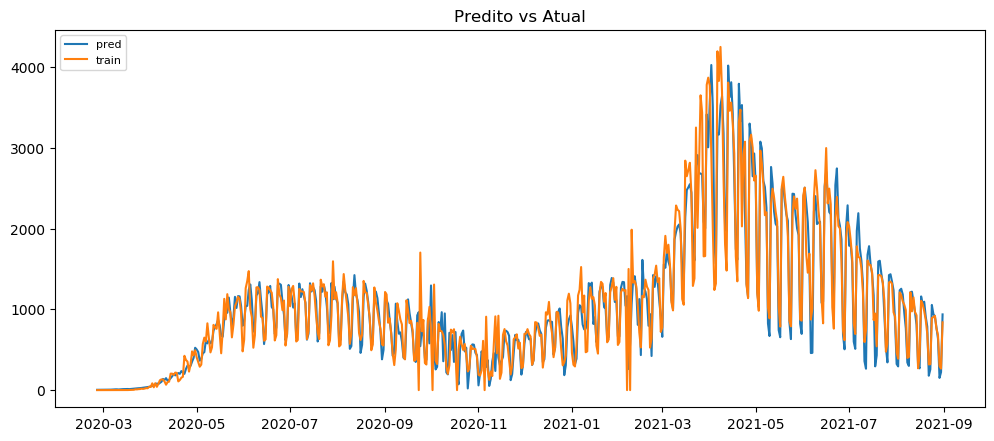

In [580]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(results.predict(tpe="levels"), label='pred')
plt.plot(train, label='train')



plt.title('Predito vs Atual')
plt.legend(loc='upper left', fontsize=8)
plt.show()

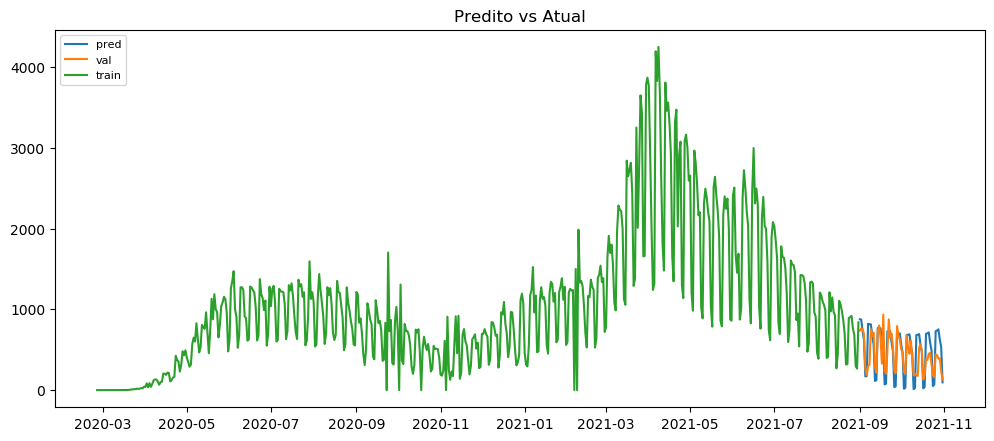

In [581]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(pred.astype(float), label='pred')
plt.plot(test, label='val')
plt.plot(train, label='train')



plt.title('Predito vs Atual')
plt.legend(loc='upper left', fontsize=8)
plt.show()

##### Testando o modelo com auto_arima

In [505]:
import pmdarima as pm
smodel = pm.auto_arima(df_brasil, start_p=1, start_q=1,
                         test='adf',
                         max_p=5, max_q=5, m=7,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=8445.637, Time=3.25 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=8646.982, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=8564.541, Time=1.38 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=8584.421, Time=1.07 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=8645.070, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=8608.379, Time=1.32 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=8446.874, Time=4.41 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=8446.873, Time=15.08 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=8507.494, Time=2.95 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=inf, Time=12.60 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=8554.448, Time=1.77 sec
 ARIMA(2,0,1)(0,1,1)[7] intercept   : AIC=8445.345, Time=4.38 sec
 ARIMA(2,0,1)(0,1,0)[7] intercept   : AIC=8612.309, Time=0.99 sec
 ARIMA(2,0,1)(1,1,1)[7] intercept   : AIC=8450.028, Time=4.98 sec
 ARIMA(2,0,1)(0,1,2)[7] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  614
Model:             SARIMAX(3, 0, 2)x(0, 1, [1], 7)   Log Likelihood               -4207.502
Date:                             Sat, 06 Nov 2021   AIC                           8429.004
Time:                                     14:36:28   BIC                           8459.864
Sample:                                          0   HQIC                          8441.011
                                             - 614                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.1139      0.030     69.766      0.000       2.055       2.173
ar.L2         -1.2745      0.054    -23.495      0.000      -1.381      -1.168
ar.L3          0.1574      0.027      5.938      0.000       0.105       0.209
ma.L1         -1.8900      0.024    -77.411      0.000      -1.938      -1.842
ma.L2          0.9117      0.023     39.566      0.000       0.866       0.957
ma.S.L7       -0.6543      0.027    -24.662      0.000      -0.706      -0.602
sigma2       6.66e+04   2276.239     29.261      0.000    6.21e+04    7.11e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):              1144.49
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               3.73   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""